# GTFS Map Matching

Map GTFS lines to OSM street segments, so we can determine the level of service on a corridor for the purposes of SB 827 implementation and mapping.

In [111]:
import pandas as pd
import numpy as np
import gtfstk
from collections import defaultdict
import time
import math
import requests
import json
import polyline
import geojsonio
import shapely.geometry
import shapely.ops
import itertools
import functools
import pyproj

DATE = '20180109' # Tuesday

In [3]:
# Read the LA Metro GTFS, first just the rail feed to save memory
# Yes, I know, the variable is called rail but we're reading the bus feed. Please ignore it.
rail = gtfstk.feed.read_gtfs('../gtfs/gtfs_bus.zip', dist_units='m')

In [4]:
# Screw with indexing to make things faster/easier
rail.stop_times.set_index(['trip_id', 'stop_sequence'], inplace=True, drop=False)
rail.trips.set_index('trip_id', inplace=True, drop=False)
rail.stops.set_index('stop_id', inplace=True, drop=False)

In [5]:
# Find patterns
class PatternKey(object):
    def __init__(self, pattern):
        self.pattern = tuple(pattern) # make sure it's immutable
    
    def __hash__(self):
        # So we can use as a dict key
        return sum(map(lambda x: hash(x[0]) * 2 ** x[1], zip(self.pattern, range(len(self.pattern)))))
                   
    def __repr__(self):
        return f'Pattern with stops {self.pattern.__repr__()}'
    
    def __eq__(self, other):
        return self.pattern == other.pattern
    
tripsByPattern = defaultdict(list)

i = 0
nTrips = len(rail.trips)
startTime = time.time()
print(f'Finding patterns for {nTrips} trips')

# This is hugely slow compared to Conveyal gtfs-lib, but I'm an academic now so I don't have to write
# efficient code...
# (seriously though, 172 seconds for 10000 trips, what is it *doing*? I could almost do it by hand that fast)
for tripId in rail.trips.trip_id:
    if i % 500 == 0:
        print(f'  {i} / {nTrips} processed')
    i += 1
    
    # Skip trips that don't run on the sample day right here, so we don't have to even think about them later
    if not gtfstk.trips.is_active_trip(rail, tripId, DATE):
        continue
    
    stopTimes = rail.stop_times[rail.stop_times.trip_id == tripId]
    # Sort them (TODO necessary? Might they already be sorted, à la Conveyal gtfs-lib?)
    # But if they are already sorted the sort algorithm should finish very quickly anyhow
    orderedStopTimes = np.argsort(stopTimes.stop_sequence)
    key = PatternKey(stopTimes.stop_id.iloc[orderedStopTimes])
    tripsByPattern[key].append(tripId)
    
print(f'Found {len(tripsByPattern)} patterns for {nTrips} trips in {(time.time() - startTime):1f}s')
    
        

Finding patterns for 31784 trips
  0 / 31784 processed
  500 / 31784 processed
  1000 / 31784 processed
  1500 / 31784 processed
  2000 / 31784 processed
  2500 / 31784 processed
  3000 / 31784 processed
  3500 / 31784 processed
  4000 / 31784 processed
  4500 / 31784 processed
  5000 / 31784 processed
  5500 / 31784 processed
  6000 / 31784 processed
  6500 / 31784 processed
  7000 / 31784 processed
  7500 / 31784 processed
  8000 / 31784 processed
  8500 / 31784 processed
  9000 / 31784 processed
  9500 / 31784 processed
  10000 / 31784 processed
  10500 / 31784 processed
  11000 / 31784 processed
  11500 / 31784 processed
  12000 / 31784 processed
  12500 / 31784 processed
  13000 / 31784 processed
  13500 / 31784 processed
  14000 / 31784 processed
  14500 / 31784 processed
  15000 / 31784 processed
  15500 / 31784 processed
  16000 / 31784 processed
  16500 / 31784 processed
  17000 / 31784 processed
  17500 / 31784 processed
  18000 / 31784 processed
  18500 / 31784 processed
  1

In [6]:
patterns = list()
rail.trips['pattern_id'] = pd.Series(np.full(len(rail.trips), -1, dtype='int'), index=rail.trips.index)

idx = 0
for pattern, trips in tripsByPattern.items():
    patterns.append(pattern.pattern)
    rail.trips.loc[trips, 'pattern_id'] = idx
    idx += 1

# Match each pattern to the street network

In [6]:
# Read OSM
class Node(object):
    def __init__ (self, node):
        self.node_id = node.ref
        self.lat = node.lat
        self.lon = node.lon
    
    def __hash__ (self):
        return hash(self.node_id)
    
    def __eq__ (self, o):
        # trickery here: this allows us to add edges with just raw integer node ids instead of
        # node objects and have them connected correctly, because the Node objects share hashcodes
        # with the IDs and are considered equal to an int with their ID.
        # #toocleverbyhalf
        if (type(o) == int):
            return o == self.node_id
        else:
            return o.node_id == self.node_id
    
class Handler(osmium.SimpleHandler):
    def __init__ (self):
        super(Handler, self).__init__()
        self.nodes = Counter()
        self.ways = []
        self.edges = []
        
    def way (self, way):        
        if 'highway' in way.tags:
            nodeRefs = []
            for node in way.nodes:
                self.nodes[Node(node)] += 1
                nodeRefs.append(node.ref)
            self.ways.append(nodeRefs)
    
    def buildGraph (self):
        G = nx.DiGraph()
        for node, count in self.nodes.items():
            if count > 1:
                # Houston, we have an intersection
                G.add_node(node)
        
        # Create a dictionary with all nodes
        nodes = {i.node_id: i for i in G.nodes()}
        
        edgeId = 0
        for way in self.ways:
            fromNode = None
            for node in way:
                # The nodes are just the OSM IDs, but that's okay because the Node class is designed to
                # be considered equal to a raw integer ID
                if G.has_node(node):
                    if fromNode:
                        fr = nodes[fromNode]
                        to = nodes[node]
                        dx = fr.lon - to.lon
                        dy = fr.lat - to.lat
                        dx *= math.cos(fr.lon)
                        dist = (dx ** 2 + dy ** 2) ** 0.5
                        e = Edge(id=edgeId, startNode=fromNode, endNode=node, cost=dist, reverse_cost=dist)
                        G.add_edge(fromNode, node, edge=e)
                        G.add_edge(node, fromNode, edge=e.reversed_edge())
                    fromNode = node
                        
        return G
                    
            
    
    
h = Handler()
h.apply_file('../data/la.osm.pbf', locations=True)
graph = h.buildGraph()
        

NameError: name 'osmium' is not defined

In [25]:
graph.number_of_edges()

0

# Map matching

Use a Valhalla service to match each route to OSM edges.

In [7]:
# Represent an edge
class Edge(object):
    def __init__(self, edge, shape):
        self.vid = edge['id']
        self.geom = shape[edge['begin_shape_index']:edge['end_shape_index'] + 1]
        self.patterns = []
        self.peakMaxHeadway = None

In [8]:
edges = dict()

# Process all patterns
i = 0
for pidx, pattern in zip(range(len(patterns)), patterns):
    if i % 10 == 0:
        print(f'pattern {i} / {len(patterns)}')
    i += 1
    
    trips = rail.trips[rail.trips.pattern_id == pidx].trip_id
    if len(trips) == 0:
        continue
    
    # Use shape information if available
    gj = gtfstk.trip_to_geojson(rail, trips[0])
    if 'features' in gj:
        coords = [
            {'lon': x[0], 'lat': x[1]}
            for x in gj['features'][0]['geometry']['coordinates']
        ]
    else:
        coords = [
            {'lon': rail.stops.stop_lon[stop_id], 'lat': rail.stops.stop_lat[stop_id]}
            for stop_id in pattern
        ]
            
    req = requests.post('http://localhost:8002/trace_attributes', data=json.dumps({'shape': coords, 'costing': 'auto', 'shape_match': 'map_snap'}))
    res = req.json()
    shape = [(x[1], x[0]) for x in polyline.decode(res['shape'], precision=6)]
    
    for edge in res['edges']:
        if not edge['id'] in edges:
            edges[edge['id']] = Edge(edge, shape)
        
        edges[edge['id']].patterns.append(pidx)
    

pattern 0 / 1032
pattern 10 / 1032
pattern 20 / 1032
pattern 30 / 1032
pattern 40 / 1032
pattern 50 / 1032
pattern 60 / 1032
pattern 70 / 1032
pattern 80 / 1032
pattern 90 / 1032
pattern 100 / 1032
pattern 110 / 1032
pattern 120 / 1032
pattern 130 / 1032
pattern 140 / 1032
pattern 150 / 1032
pattern 160 / 1032
pattern 170 / 1032
pattern 180 / 1032
pattern 190 / 1032
pattern 200 / 1032
pattern 210 / 1032
pattern 220 / 1032
pattern 230 / 1032
pattern 240 / 1032
pattern 250 / 1032
pattern 260 / 1032
pattern 270 / 1032
pattern 280 / 1032
pattern 290 / 1032
pattern 300 / 1032
pattern 310 / 1032
pattern 320 / 1032
pattern 330 / 1032
pattern 340 / 1032
pattern 350 / 1032
pattern 360 / 1032
pattern 370 / 1032
pattern 380 / 1032
pattern 390 / 1032
pattern 400 / 1032
pattern 410 / 1032
pattern 420 / 1032
pattern 430 / 1032
pattern 440 / 1032
pattern 450 / 1032
pattern 460 / 1032
pattern 470 / 1032
pattern 480 / 1032
pattern 490 / 1032
pattern 500 / 1032
pattern 510 / 1032
pattern 520 / 1032
patt

In [9]:
# Display the street-matched edges
data = {
    'type': 'FeatureCollection',
    'features': [{
        'id': e.vid,
        'type': 'Feature',
        'properties': {},
        'geometry': {
            'type': 'LineString',
            'coordinates': e.geom
        }
    } for e in edges.values()]
}

with open('processed_network.json', 'w') as out:
    json.dump(data, out)

In [130]:
# Figure out the number of departures during the peak
# Merge pattern IDs to stop times table
stp = rail.stop_times.join(rail.trips.pattern_id)
stp['pattern_id'] = stp['pattern_id'].astype('category')
stp['stop_id'] = stp['stop_id'].astype('category')

# Convert GTFS time to seconds since midnight
def toSecs(x):
    h, m, s = x.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)

toSecs = np.vectorize(toSecs)

def processEdges():
    lenEdges = len(edges)
    i = 0
    for edge in edges.values():
        if i % 1000 == 0:
            print(f'edge {i}/{lenEdges} ({i/lenEdges * 100:.3f}%)')
        i += 1

        departures = []
        for pidx in edge.patterns:
            pattern = patterns[pidx]
            # find nearest stop
            dx = (rail.stops.loc[pattern, 'stop_lon'] - edge.geom[0][0]) * math.cos(math.radians(edge.geom[0][1]))
            dy = rail.stops.loc[pattern, 'stop_lat'] - edge.geom[0][1]
            squared = dx ** 2 + dy ** 2 # No need for square root, we're just looking for the closest
            nearestStop = pattern[squared.values.argmin()]

            depTimes = stp.departure_time[(stp.stop_id == nearestStop) & (stp.pattern_id == pidx)]
            departures += toSecs(depTimes).tolist()

        departures = np.array(departures)
        # Departures between 7 and 9 AM
        amPeakDepartures = departures[(departures > 7 * 3600) & (departures < 9 * 3600)]
        pmPeakDepartures = departures[(departures > 16 * 3600) & (departures < 18 * 3600)]

        if (len(amPeakDepartures) <= 1 or len(pmPeakDepartures) <= 1):
            continue
            
        amSortedDepartures = np.sort(amPeakDepartures)
        pmSortedDepartures = np.sort(pmPeakDepartures)
        amHeadways = np.ediff1d(amSortedDepartures)
        pmHeadways = np.ediff1d(pmSortedDepartures)
        allHeadways = np.concatenate((amHeadways, pmHeadways))
        
        edge.peakMaxHeadway = np.max(allHeadways)
        edge.headway85pct = np.percentile(allHeadways, 85)
        edge.headwayMean = np.mean(allHeadways)
        edge.experiencedMean = np.sum(np.square(allHeadways)) / np.sum(allHeadways)
        
processEdges()

edge 0/81106 (0.000%)
edge 1000/81106 (1.233%)
edge 2000/81106 (2.466%)
edge 3000/81106 (3.699%)
edge 4000/81106 (4.932%)
edge 5000/81106 (6.165%)
edge 6000/81106 (7.398%)
edge 7000/81106 (8.631%)
edge 8000/81106 (9.864%)
edge 9000/81106 (11.097%)
edge 10000/81106 (12.330%)
edge 11000/81106 (13.562%)
edge 12000/81106 (14.795%)
edge 13000/81106 (16.028%)
edge 14000/81106 (17.261%)
edge 15000/81106 (18.494%)
edge 16000/81106 (19.727%)
edge 17000/81106 (20.960%)
edge 18000/81106 (22.193%)
edge 19000/81106 (23.426%)
edge 20000/81106 (24.659%)
edge 21000/81106 (25.892%)
edge 22000/81106 (27.125%)
edge 23000/81106 (28.358%)
edge 24000/81106 (29.591%)
edge 25000/81106 (30.824%)
edge 26000/81106 (32.057%)
edge 27000/81106 (33.290%)
edge 28000/81106 (34.523%)
edge 29000/81106 (35.756%)
edge 30000/81106 (36.989%)
edge 31000/81106 (38.222%)
edge 32000/81106 (39.455%)
edge 33000/81106 (40.687%)
edge 34000/81106 (41.920%)
edge 35000/81106 (43.153%)
edge 36000/81106 (44.386%)
edge 37000/81106 (45.61

In [134]:
#highQuality = [e for e in edges.values() if e.peakMaxHeadway < 8 * 60] # 16 not 15 to account for sub-minute variation
#len(highQuality)

# Display the street-matched edges
data = {
    'type': 'FeatureCollection',
    'features': [{
        'id': e.vid,
        'type': 'Feature',
        'properties': {
            'peakMaxHeadway': int(e.peakMaxHeadway) if e.peakMaxHeadway is not None else None,
            'headway85pct': int(e.headway85pct) if hasattr(e, 'headway85pct') else None,
            'headwayMean': int(e.headwayMean) if hasattr(e, 'headwayMean') else None,
            'experiencedMean': int(e.experiencedMean) if hasattr(e, 'experiencedMean') else None

        },
        'geometry': {
            'type': 'LineString',
            'coordinates': e.geom
        }
    } for e in edges.values()]
}

with open('processed_network.json', 'w') as out:
    json.dump(data, out)

In [61]:
geoms = [f['geometry'] for f in data['features'] if f['properties']['peakMaxHeadway'] is not None and f['properties']['peakMaxHeadway'] < 16 * 60]
shapes = [shapely.geometry.shape(f) for f in geoms]

In [89]:
i = 0
for edge in edges.values():
    if i % 1000 == 0:
        print(f'edge {i} / {len(edges)}')
    i += 1
    edge.routes = set(rail.trips.route_id[rail.trips.pattern_id.isin(edge.patterns)])
    edge.shape = shapely.geometry.shape({ 'type': 'LineString', 'coordinates': edge.geom })
    
        

edge 0 / 81106
edge 1000 / 81106
edge 2000 / 81106
edge 3000 / 81106
edge 4000 / 81106
edge 5000 / 81106
edge 6000 / 81106
edge 7000 / 81106
edge 8000 / 81106
edge 9000 / 81106
edge 10000 / 81106
edge 11000 / 81106
edge 12000 / 81106
edge 13000 / 81106
edge 14000 / 81106
edge 15000 / 81106
edge 16000 / 81106
edge 17000 / 81106
edge 18000 / 81106
edge 19000 / 81106
edge 20000 / 81106
edge 21000 / 81106
edge 22000 / 81106
edge 23000 / 81106
edge 24000 / 81106
edge 25000 / 81106
edge 26000 / 81106
edge 27000 / 81106
edge 28000 / 81106
edge 29000 / 81106
edge 30000 / 81106
edge 31000 / 81106
edge 32000 / 81106
edge 33000 / 81106
edge 34000 / 81106
edge 35000 / 81106
edge 36000 / 81106
edge 37000 / 81106
edge 38000 / 81106
edge 39000 / 81106
edge 40000 / 81106
edge 41000 / 81106
edge 42000 / 81106
edge 43000 / 81106
edge 44000 / 81106
edge 45000 / 81106
edge 46000 / 81106
edge 47000 / 81106
edge 48000 / 81106
edge 49000 / 81106
edge 50000 / 81106
edge 51000 / 81106
edge 52000 / 81106
edge 5

In [138]:
hq = [e for e in edges.values() if hasattr(e, 'headway85pct') and e.headway85pct < 15 * 60]
i = 0
lenSq = len(hq) ** 2 / 2
intersections = []
for e1, e2 in itertools.combinations(hq, 2):
    if i % 5000000 == 0:
        print(f'{i} / {lenSq} ({i / lenSq * 100:.3f}%)')
    i += 1
    
    # only intersect them if they have no routes in common (avoid an intersection everywhere a route continues onto
    # a new edge)
    if e1.routes.isdisjoint(e2.routes) and e1.shape.intersects(e2.shape):
        inter = e1.shape.intersection(e2.shape)
        if not inter.is_empty and inter.geom_type == 'Point':
            intersections.append(inter)

0 / 444616200.0 (0.000%)
5000000 / 444616200.0 (1.125%)
10000000 / 444616200.0 (2.249%)
15000000 / 444616200.0 (3.374%)
20000000 / 444616200.0 (4.498%)
25000000 / 444616200.0 (5.623%)
30000000 / 444616200.0 (6.747%)
35000000 / 444616200.0 (7.872%)
40000000 / 444616200.0 (8.997%)
45000000 / 444616200.0 (10.121%)
50000000 / 444616200.0 (11.246%)
55000000 / 444616200.0 (12.370%)
60000000 / 444616200.0 (13.495%)
65000000 / 444616200.0 (14.619%)
70000000 / 444616200.0 (15.744%)
75000000 / 444616200.0 (16.868%)
80000000 / 444616200.0 (17.993%)
85000000 / 444616200.0 (19.118%)
90000000 / 444616200.0 (20.242%)
95000000 / 444616200.0 (21.367%)
100000000 / 444616200.0 (22.491%)
105000000 / 444616200.0 (23.616%)
110000000 / 444616200.0 (24.740%)
115000000 / 444616200.0 (25.865%)
120000000 / 444616200.0 (26.990%)
125000000 / 444616200.0 (28.114%)
130000000 / 444616200.0 (29.239%)
135000000 / 444616200.0 (30.363%)
140000000 / 444616200.0 (31.488%)
145000000 / 444616200.0 (32.612%)
150000000 / 44461

In [109]:
with open('intersections.json', 'w') as out:
    json.dump({
    'type': 'FeatureCollection',
    'features': [{
        'type': 'Feature',
        'properties': {},
        'geometry': {
            'type': 'Point',
            'coordinates': [i.coords.xy[0][0], i.coords.xy[1][0]]
        }
    } for i in intersections
    ]
    }, out)


In [162]:
# Project so buffering works right, http://toblerity.org/shapely/manual.html#shapely.ops.transform
tr = functools.partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:4326'),
    pyproj.Proj(init='epsg:26945') # CA State Plane Zone 5, meters
)

pintersections = shapely.ops.transform(tr, shapely.ops.cascaded_union(intersections))
phq = shapely.ops.transform(tr, shapely.ops.cascaded_union([i.shape for i in hq]))

bint = pintersections.buffer(804.5)
hqint = phq.buffer(402.25)

In [163]:
# Pull in data for metrolink and metro rail for rail stations
metrorail = gtfstk.feed.read_gtfs('../gtfs/gtfs_rail.zip', 'm')
metrolink = gtfstk.feed.read_gtfs('../gtfs/google_transit.zip', 'm')

metrorailStopsWithService = metrorail.stops.stop_id.isin(set(metrorail.stop_times.stop_id))
metrolinkStopsWithService = metrolink.stops.stop_id.isin(set(metrolink.stop_times.stop_id))

pstops = shapely.ops.transform(tr, shapely.ops.cascaded_union(
    [shapely.geometry.Point(i) for i in zip(metrorail.stops[metrorailStopsWithService].stop_lon, metrorail.stops[metrorailStopsWithService].stop_lat)] +
    [shapely.geometry.Point(i) for i in zip(metrolink.stops[metrolinkStopsWithService].stop_lon, metrolink.stops[metrolinkStopsWithService].stop_lat)]
))
bstops = pstops.buffer(804.5)

In [164]:
# Smallest area is a 1mi straight line with a 1/4mi buffer
smallestArea = (
    1 / 2 + # area of  1/4 mile buffer on either side
    math.pi * 1 / 4 ** 2 # area of two endcaps
) * (1609 ** 2) # miles to meters
hqCleaned = shapely.ops.cascaded_union([g for g in hqint.geoms if g.area > smallestArea])

In [165]:
affectedArea = shapely.ops.cascaded_union([hqCleaned, bint, bstops])

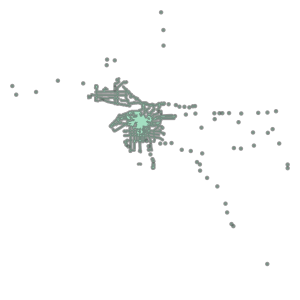

In [166]:
affectedArea

In [173]:
reversetr = functools.partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:26945'), # CA State Plane Zone 5, meters
    pyproj.Proj(init='epsg:4326')
)

with open('area.json', 'w') as out:
    json.dump({
        'type': 'FeatureCollection',
        'features': [{
            'id': 0,
            'properties': {},
            'geometry': shapely.geometry.mapping(g)
        } for g in shapely.ops.transform(reversetr, affectedArea).geoms]
    }, out)